In [216]:
# Import Libaries
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import preprocessing

import numpy as np

import statsmodels.tsa as tsa
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot

sns.set_theme(style="whitegrid")

import warnings
warnings.filterwarnings('ignore')

In [217]:
def broadbent_adstock(grp, r):
    adstock = np.zeros(len(grp))
    adstock[0] = grp[0]
    for i in range(1,len(grp)):
        adstock[i] = grp[i] + r*adstock[i-1]
    return adstock

def optimize_adstock(grp, sales):
    corrs = []
    rates = np.arange(0, 1.05, 0.01)
    rmax = 0
    corrmax = -1

    for r in rates:
        x = broadbent_adstock(grp.copy(), r)
        y = sales
        corr = np.corrcoef(x, y)[0][1]
        corrs.append(corr)
        if corr > corrmax:
            rmax = r
            corrmax = corr
                
    plt.title("Correlation by Decay Rate")
    plt.plot(rates, corrs, label="Correlation")
    plt.xlabel("Decay Rate")
    plt.ylabel("Correlation")
    plt.legend()
    plt.show()
    
    print('忘却率が{0}のとき相関係数は最大値{1}'.format(rmax, corrmax))

In [218]:
df=pd.read_csv("MMM_data.csv")

In [219]:
# Drop irrelevant columns
df.drop(columns=["TV Manufacturing Brand"], inplace=True)

In [220]:
# FORMAT DATE COLUMN
df["DATE"] = pd.to_datetime(df["DATE"])
df.set_index("DATE", inplace=True)

In [221]:
# Rename
new_columns = ["DEMAND", "CPI", "CCI", "PPI", "UNIT_PRICE", "POS", "SALES", "SMS_EXP", "NEWSPAPER_EXP", "RADIO_EXP", "TV_EXP", "INTERNET_EXP",
               "NEWSPAPER_GRP", "SMS_GRP", "RADIO_GRP", "INTERNET_GRP", "TV_GRP"]

df.columns = new_columns

# Exploratory Analysis

Check for Na

In [222]:
# No Empty rows
df.isna().sum()

DEMAND           0
CPI              0
CCI              0
PPI              0
UNIT_PRICE       0
POS              0
SALES            0
SMS_EXP          0
NEWSPAPER_EXP    0
RADIO_EXP        0
TV_EXP           0
INTERNET_EXP     0
NEWSPAPER_GRP    0
SMS_GRP          0
RADIO_GRP        0
INTERNET_GRP     0
TV_GRP           0
dtype: int64

In [223]:
df.head()

,DEMAND,CPI,CCI,PPI,UNIT_PRICE,POS,SALES,SMS_EXP,NEWSPAPER_EXP,RADIO_EXP,TV_EXP,INTERNET_EXP,NEWSPAPER_GRP,SMS_GRP,RADIO_GRP,INTERNET_GRP,TV_GRP
DATE,,,,,,,,,,,,,,,,,
2010-01-01,4384,104.9,96.3,106.7,361.62,4240,1533268.80,77.4819,14.104193,112.3370,1479.4565,722.571,95.333,11.8398,91.0000,276.3636,756.5909
2010-01-02,4366,104.9,96.3,106.7,361.62,4266,1542670.92,73.4783,13.298758,105.7133,1369.8913,717.857,114.957,27.8039,111.9091,291.3182,860.1364
2010-01-03,4006,104.9,96.3,106.7,361.62,4206,1520973.72,80.6093,13.200691,108.7702,1428.0645,653.333,113.090,0.0000,94.6364,282.7273,751.9545
2010-01-04,4076,104.9,96.3,106.7,361.62,4176,1510125.12,65.9319,12.721429,93.3065,1309.3548,622.095,72.442,0.0000,98.5909,306.3182,749.4545
2010-01-05,4834,104.9,96.3,106.7,361.62,5234,1892719.08,77.4819,14.104193,112.3370,1479.4565,722.571,95.333,11.8398,91.0000,276.3636,756.5909


In [224]:
df.describe()

,DEMAND,CPI,CCI,PPI,UNIT_PRICE,POS,SALES,SMS_EXP,NEWSPAPER_EXP,RADIO_EXP,TV_EXP,INTERNET_EXP,NEWSPAPER_GRP,SMS_GRP,RADIO_GRP,INTERNET_GRP,TV_GRP
count,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2.613000e+03,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000
mean,5021.434367,102.609989,103.152315,102.238232,363.275128,4522.970915,1.641507e+06,60.388495,12.651179,88.074643,1324.501468,3079.184067,505.296876,30.618203,139.437260,286.228665,1146.114128
std,2681.197808,1.381355,3.167221,2.037774,26.372958,2603.996535,9.416673e+05,13.557190,1.117926,12.569956,123.677327,1520.891014,488.147782,31.570754,146.042432,138.406620,822.991163
min,1610.000000,101.300000,96.300000,99.500000,282.140000,1510.000000,4.627096e+05,37.916700,10.027128,62.968800,1067.155700,0.000000,5.659000,0.000000,66.863600,191.181800,697.636400
25%,2436.000000,101.400000,102.700000,100.400000,361.600000,1776.000000,6.717679e+05,47.554100,11.885714,78.098100,1251.250000,2226.429000,114.957000,0.000000,95.136400,234.954500,849.545500
50%,4636.000000,102.300000,103.600000,102.700000,361.620000,4412.000000,1.605095e+06,61.267900,13.186582,84.129200,1380.696200,3302.667000,221.528000,26.119600,109.636400,261.454500,928.545500
75%,6834.000000,103.400000,104.600000,103.500000,361.620000,6266.000000,2.267206e+06,71.012200,13.437482,98.639000,1416.171400,4237.095000,854.310000,46.782000,126.045500,291.318200,1114.863600
max,18565.000000,106.500000,107.900000,107.200000,400.100000,16482.000000,5.960221e+06,89.728300,14.104193,118.467700,1479.456500,6354.571000,1791.183000,144.995100,1169.409100,1540.429400,7307.318200


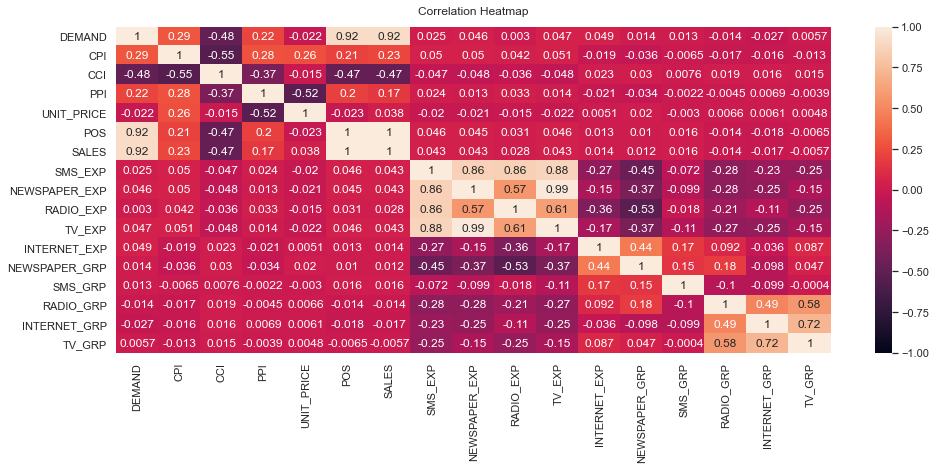

In [225]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

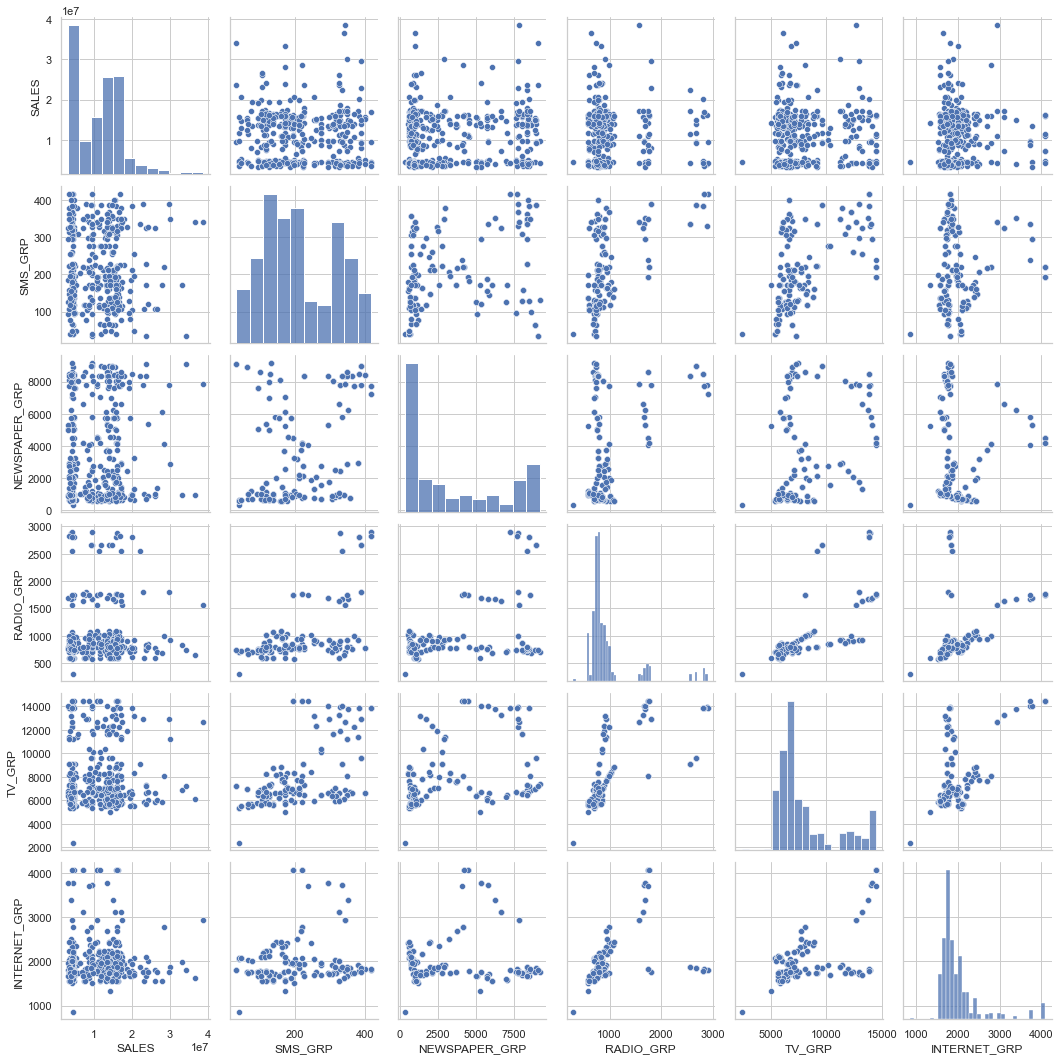

In [226]:
sns.pairplot(df.resample("w").sum()[['SALES', 'SMS_GRP','NEWSPAPER_GRP', 'RADIO_GRP', 'TV_GRP', 'INTERNET_GRP']])

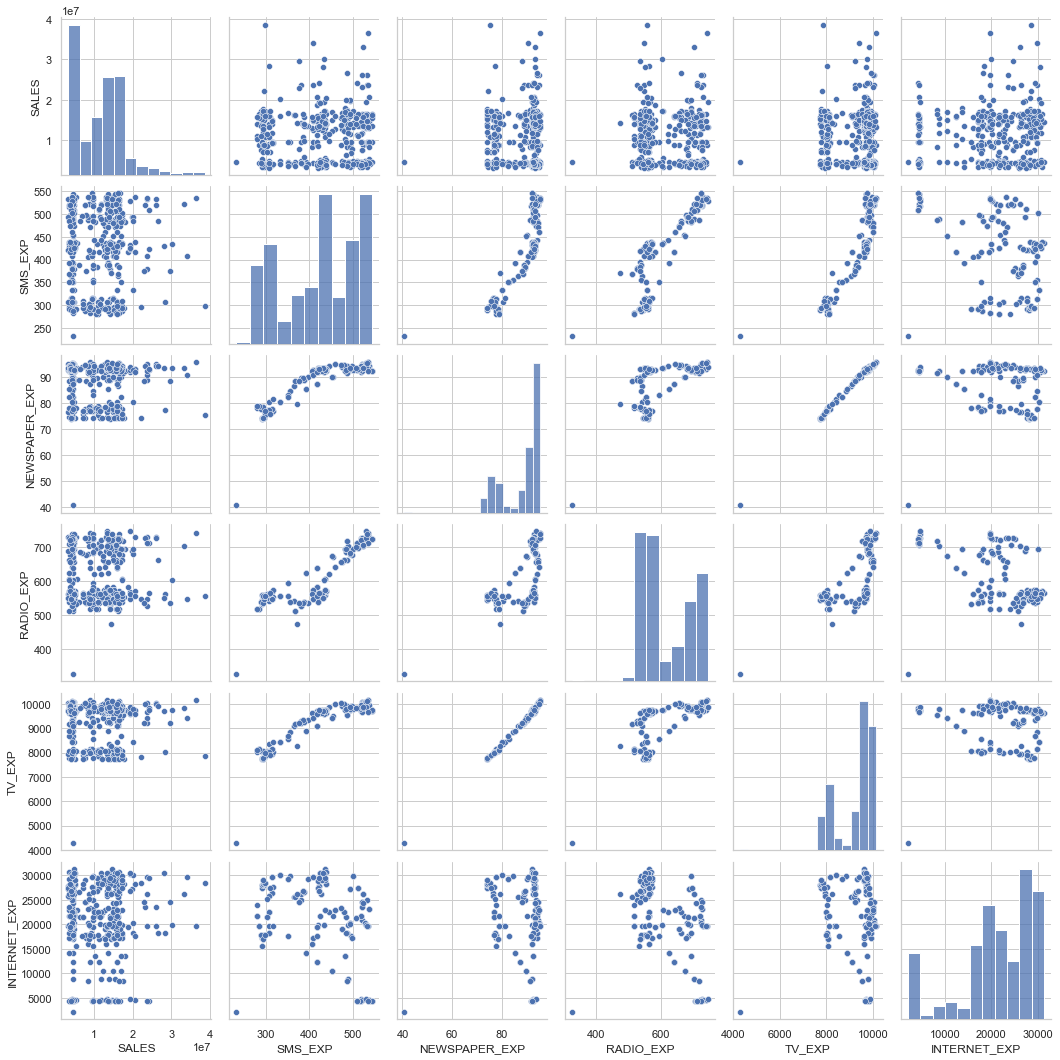

In [227]:
sns.pairplot(df.resample("w").sum()[['SALES', 'SMS_EXP','NEWSPAPER_EXP', 'RADIO_EXP', 'TV_EXP', 'INTERNET_EXP']])

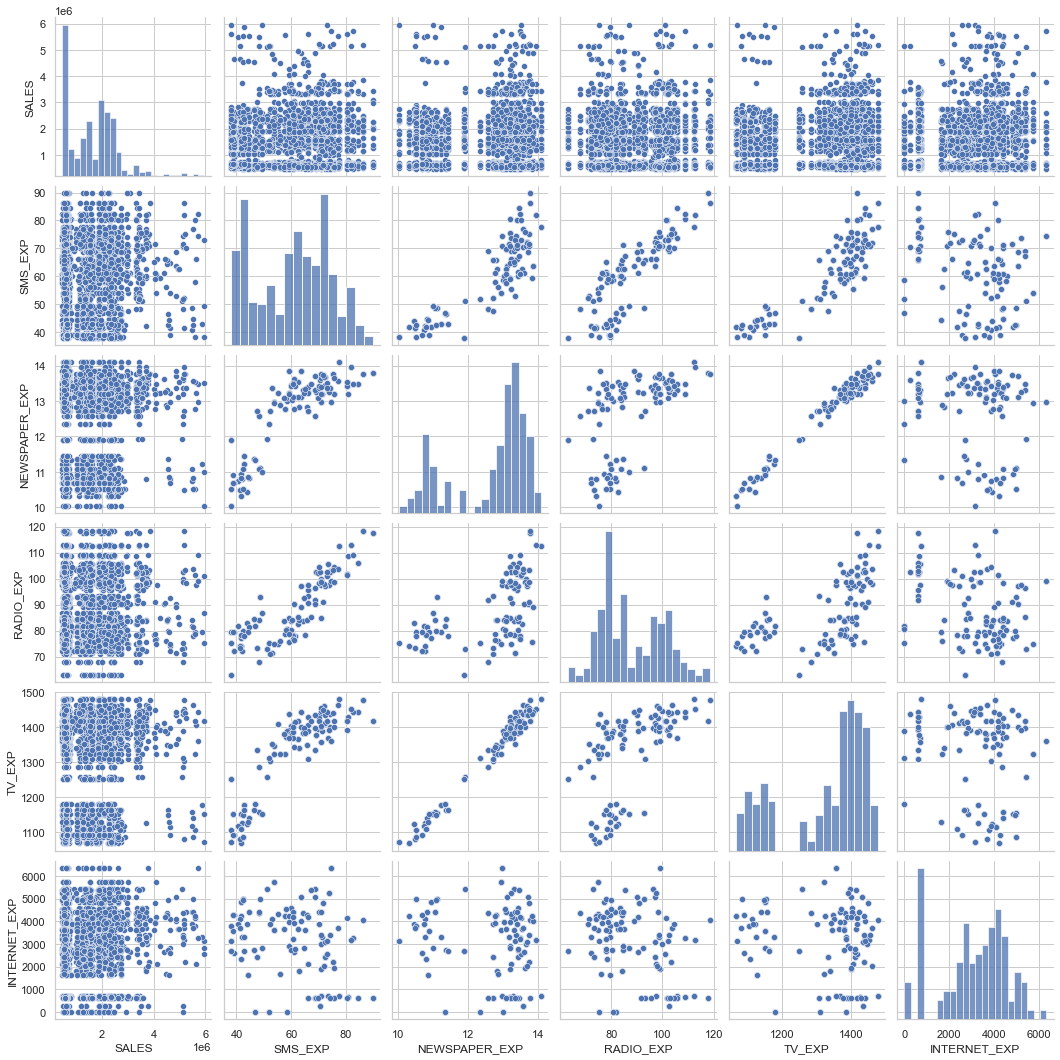

In [228]:
sns.pairplot(df[['SALES', 'SMS_EXP','NEWSPAPER_EXP', 'RADIO_EXP', 'TV_EXP', 'INTERNET_EXP']])

In [229]:
import math

In [230]:
def week_of_month(dt):
    """ Returns the week of the month for the specified date.
    """

    first_day = dt.replace(day=1)

    dom = dt.day
    adjusted_dom = dom + first_day.weekday()

    return int(math.ceil(adjusted_dom/7.0))

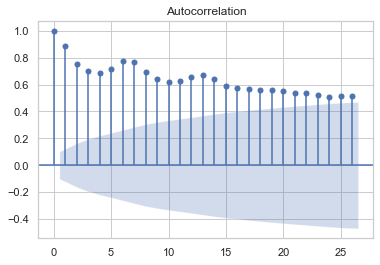

In [231]:
from statsmodels.graphics.tsaplots import plot_acf


plot_acf(df["SALES"].resample("w").sum());

In [232]:
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(df['SALES'], autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -7.022538941204617
2. P-Value :  6.487463282208943e-10
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 2612
5. Critical Values :
	 1% :  -3.4328560253199973
	 5% :  -2.8626471695439784
	 10% :  -2.567359385689561


In [233]:
# # Aggregate into weekly
# df=df.resample("w").sum()

In [234]:
def create_dummies(df, column_name):
    df_temp = pd.get_dummies(df[column_name], drop_first=True)
    df_temp.columns = ["{}_{}".format(column_name, str(col)) for col in df_temp.columns]
    df = pd.merge(df, df_temp, left_index=True, right_index=True)
    df.drop(columns=[column_name], inplace=True)
    return df

df["week-of-month"] = pd.DataFrame(pd.DatetimeIndex(df.index))["DATE"].apply(lambda x: week_of_month(x)).values
df["year"] = pd.DatetimeIndex(df.index).year
df["month"] = pd.DatetimeIndex(df.index).month

In [236]:
# # Aggregate into weekly
# df=df.resample("w").sum()

In [237]:
df=create_dummies(df, "week-of-month")
df=create_dummies(df,"year")
df=create_dummies(df, "month")

In [274]:
import prohet

ModuleNotFoundError: No module named 'prohet'

<AxesSubplot:xlabel='DATE'>

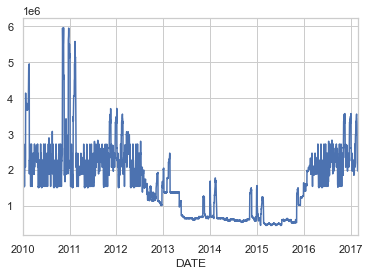

In [261]:
df["SALES"].plot()

In [242]:
TEMP=df[["SALES"]]-df[["SALES"]].shift()
df["DESEASONAL_SALES"] = TEMP.SALES

In [266]:
for i in df.year.unique():
    print(i)

AttributeError: 'DataFrame' object has no attribute 'year'

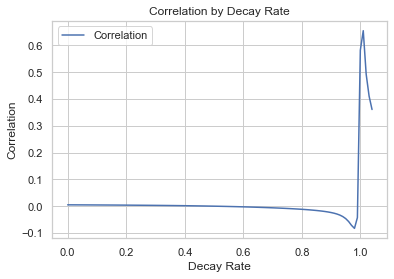

忘却率が1.01のとき相関係数は最大値0.6549085534849801


In [273]:
temp_df = df[df.index > "2013"]
optimize_adstock(temp_df["TV_GRP"].values, temp_df["SALES"].values)

In [ ]:
1.01

In [ ]:
time_end = datetime.datetime.now()
time_spend_vectorized = time_end - time_start
print '\n Time spend for ad stock transformation in vectorized and fast way:  \n', time_spend_vectorized
print '\n First ten rows of data including ad stock values:  \n', data_ad_stocks[:10]

#calculate speed up factor
speed_up_factor = time_spend_non_vectorized.total_seconds() / time_spend_vectorized.total_seconds()
print '\n Speed up factor:  \n', speed_up_factor

In [126]:
df.columns

Index(['DEMAND', 'CPI', 'CCI', 'PPI', 'UNIT_PRICE', 'POS', 'SALES', 'SMS_EXP',
       'NEWSPAPER_EXP', 'RADIO_EXP', 'TV_EXP', 'INTERNET_EXP', 'NEWSPAPER_GRP',
       'SMS_GRP', 'RADIO_GRP', 'INTERNET_GRP', 'TV_GRP', 'week-of-month_2',
       'week-of-month_3', 'week-of-month_4', 'week-of-month_5', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
       'year_2017', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def broadbent_adstock(grp, r):
    adstock = np.zeros(len(grp))
    adstock[0] = grp[0]
    for i in range(1,len(grp)):
        adstock[i] = grp[i] + r*adstock[i-1]
    return adstock



In [ ]:
def optimize_adstock(grp, sales):
    corrs = []
    rates = np.arange(0, 1.01, 0.01)
    rmax = 0
    corrmax = -1

    for r in rates:
            x = broadbent_adstock(grp.copy(), r)
            y = sales
            corr = np.corrcoef(x, y)[0][1]
            corrs.append(corr)
            if corr > corrmax:
                rmax = r
                corrmax = corr
                
    plt.title("Correlation by Decay Rate")
    plt.plot(rates, corrs, label="Correlation")
    plt.xlabel("Decay Rate")
    plt.ylabel("Correlation")
    plt.legend()
    plt.show()

In [143]:
X = df[[ 'RADIO_EXP', 'TV_EXP', 'INTERNET_EXP', 'NEWSPAPER_GRP',
'SMS_GRP', 'RADIO_GRP', 'INTERNET_GRP', 'TV_GRP', 'week-of-month_2',
'week-of-month_3', 'week-of-month_4', 'week-of-month_5', 'year_2011',
'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
'year_2017', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12']]


X = X.assign(const=1)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data)

            feature         VIF
0         RADIO_EXP    3.741284
1            TV_EXP    3.632161
2      INTERNET_EXP    1.663964
3         RADIO_GRP    2.654538
4      INTERNET_GRP    2.367360
5            TV_GRP    3.550212
6   week-of-month_2    1.548001
7   week-of-month_3    1.548811
8   week-of-month_4    1.543091
9   week-of-month_5    1.282997
10        year_2011    1.735801
11        year_2012    1.743705
12        year_2013    1.733137
13        year_2014    1.738397
14        year_2015    1.732645
15        year_2016    1.728519
16        year_2017    1.273743
17          month_2    1.761580
18          month_3    1.784602
19          month_4    1.735555
20          month_5    1.786640
21          month_6    1.772859
22          month_7    1.807148
23          month_8    1.786507
24          month_9    1.744372
25         month_10    1.784654
26         month_11    1.777200
27         month_12    1.749383
28            const  340.367592


In [ ]:
'SALES', 

In [125]:
df

,DEMAND,CPI,CCI,PPI,UNIT_PRICE,POS,SALES,SMS_EXP,NEWSPAPER_EXP,RADIO_EXP,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
DATE,,,,,,,,,,,,,,,,,,,,,
2010-01-03,12756,314.7,288.9,320.1,1084.86,12712,4596913.44,231.5695,40.603642,326.8205,...,0,0,0,0,0,0,0,0,0,0
2010-01-10,31864,734.3,674.1,746.9,2531.34,32584,11783026.08,521.9711,92.420447,722.6765,...,0,0,0,0,0,0,0,0,0,0
2010-01-17,36801,734.3,674.1,746.9,2531.34,37681,13626203.22,515.4188,92.805371,709.9899,...,0,0,0,0,0,0,0,0,0,0
2010-01-24,53233,734.3,674.1,746.9,2531.34,54773,19807012.26,493.0872,92.657897,688.2157,...,0,0,0,0,0,0,0,0,0,0
2010-01-31,74417,734.3,674.1,746.9,2531.34,72158,26093775.96,533.0035,95.110495,729.1392,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-29,39158,709.8,702.1,723.1,2531.34,38622,13966487.64,494.3773,93.482411,683.9684,...,0,0,0,0,0,0,0,0,0,0
2017-02-05,49308,709.8,702.1,723.1,2531.34,44389,16051950.18,459.7566,95.056797,643.4807,...,0,0,0,0,0,0,0,0,0,0
2017-02-12,51993,709.8,702.1,723.1,2531.34,57059,20633675.58,416.5671,91.969872,557.5452,...,0,0,0,0,0,0,0,0,0,0


In [32]:
pd.DatetimeIndex(df.index).week

Int64Index([53, 53, 53,  1,  1,  1,  1,  1,  1,  1,
            ...
             7,  7,  7,  7,  8,  8,  8,  8,  8,  8],
           dtype='int64', name='DATE', length=2613)

In [ ]:
df_exp = 

In [ ]:
# remove years with low sales volume
model_additive = smf.ols(formula='SALES ~ RADIO_EXP_ADSTOCK + TV_EXP_ADSTOCK + INTERNET_EXP_ADSTOCK' ,data=df_2[~df_2.year.isin([2014, 2015])]).fit()
#NEWSPAPER_GRP_ADSTOCK+SMS_GRP_ADSTOCK+ RADIO_GRP_ADSTOCK+ INTERNET_GRP_ADSTOCK+ TV_GRP_ADSTOCK
expenses_model_sum = model_additive.summary()
print(expenses_model_sum)

In [ ]:
ar_coeff = .5 # 0.2, 0.3, 0.4, 0.5

df_2["SMS_EXP_ADSTOCK"] = tsa.filters.filtertools.recursive_filter(df_2['SMS_EXP'], ar_coeff).values

df_2["NEWSPAPER_EXP_ADSTOCK"] = tsa.filters.filtertools.recursive_filter(df_2['NEWSPAPER_EXP'], ar_coeff)

df_2["RADIO_EXP_ADSTOCK"] = tsa.filters.filtertools.recursive_filter(df_2['RADIO_EXP'], ar_coeff)

df_2["TV_EXP_ADSTOCK"] = tsa.filters.filtertools.recursive_filter(df_2['TV_EXP'], ar_coeff)

df_2["INTERNET_EXP_ADSTOCK"] = tsa.filters.filtertools.recursive_filter(df_2['INTERNET_EXP'], ar_coeff)

df_2["SMS_GRP_ADSTOCK"] = tsa.filters.filtertools.recursive_filter(df_2['SMS_GRP'], ar_coeff).values

df_2["NEWSPAPER_GRP_ADSTOCK"] = tsa.filters.filtertools.recursive_filter(df_2['NEWSPAPER_GRP'], ar_coeff)

df_2["RADIO_GRP_ADSTOCK"] = tsa.filters.filtertools.recursive_filter(df_2['RADIO_GRP'], ar_coeff)

df_2["TV_GRP_ADSTOCK"] = tsa.filters.filtertools.recursive_filter(df_2['TV_GRP'], ar_coeff)

df_2["INTERNET_GRP_ADSTOCK"] = tsa.filters.filtertools.recursive_filter(df_2['INTERNET_GRP'], ar_coeff)

# Getting ad stock

In [ ]:
for i in 

In [ ]:
NEWSPAPER_EXP + RADIO_EXP + TV_EXP + INTERNET_EXP + NEWSPAPER_GRP +
SMS_GRP + RADIO_GRP + INTERNET_GRP + TV_GRP + week-of-month_2 +
week-of-month_3 + week-of-month_4 + week-of-month_5 + year_2011 +
year_2012 + year_2013 + year_2014 + year_2015 + year_2016 +
year_2017 + month_2 + month_3 + month_4 + month_5 + month_6 +
month_7 + month_8 + month_9 + month_10 + month_11 + month_12

In [183]:
TEMP=df[["SALES"]]-df[["SALES"]].shift()
df["DESEASONAL_SALES"] = TEMP.SALES

In [195]:
ar_coeff = 0.5
df["RADIO_EXP_ADSTOCK"] = tsa.filters.filtertools.recursive_filter(df['RADIO_EXP'], ar_coeff)

df["TV_EXP_ADSTOCK"] = tsa.filters.filtertools.recursive_filter(df['TV_EXP'], ar_coeff)

df["INTERNET_EXP_ADSTOCK"] = tsa.filters.filtertools.recursive_filter(df['INTERNET_EXP'], ar_coeff)
# remove years with low sales volume
model_additive = smf.ols(formula='SALES ~ RADIO_EXP_ADSTOCK + INTERNET_EXP_ADSTOCK + TV_EXP_ADSTOCK + year_2011 + year_2012 + year_2013 + year_2014 + year_2015 + year_2016 + year_2017 + month_2 + month_11' , data=df).fit()


In [196]:
#NEWSPAPER_GRP_ADSTOCK+SMS_GRP_ADSTOCK+ RADIO_GRP_ADSTOCK+ INTERNET_GRP_ADSTOCK+ TV_GRP_ADSTOCK
expenses_model_sum = model_additive.summary()
print(expenses_model_sum)

                            OLS Regression Results                            
Dep. Variable:                  SALES   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     78.02
Date:                Fri, 09 Jul 2021   Prob (F-statistic):           1.85e-92
Time:                        02:53:49   Log-Likelihood:                -6149.6
No. Observations:                 374   AIC:                         1.233e+04
Df Residuals:                     361   BIC:                         1.238e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             9.065e+06 

In [192]:
model_additive.fit_regularized()

AttributeError: 'OLSResults' object has no attribute 'fit_regularized'

In [149]:
df.SALES.mean() - 1.748e+07

-6011398.49473262

In [ ]:
# 
df['']

In [ ]:
(February 1st (Tuesday), and the festival will last to February 15th,)